<a href="https://colab.research.google.com/github/SaiPavanKumarB/Liberty-Insurance-Case-Study/blob/main/Liberty_Insurance_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="black" face="Arial" size=6><center> Liberty Insurance - Case Study </center></font>


---



# Motor Insurance Claims

> Purpose of this case study is to analyze the historical data of motor insurance claims by customers & build a model that predicts the number of claims during the time frame of policy





## DATA DESCRIPTION:


*   **policy_desc**: Policy Identifier; Primary Key which is unique for every policy
*   **claim_count**: Total Claims (This is the response you should predicting); Numeric Variable
*   **cat_areacode**: Area Code; Categorical Variable
*   **num_vehicleAge**: Age of the vehicle; Numeric Variable
*   **num_noClaimDiscountPercent**: Percentage of discount applied to policy premium based on claim history. If value is greater than 100 then policy premium was increased, if it’s less than 100 a discount was applied. A value of 100 means the premium remain unchanged; Numerical Variable
*   **cat_carBrand**: Insured Vehicle Brand; Categorical Variable
*   **num_populationDensitykmsq**: Population density of the city the policy holder lives in; Numerical Variable
*   **cat_Region**: Region of the country the policy holder lives in; Categorical Variable
*   **ord_vehicleHP**: Vehicle Horsepower; This feature is anonymised but maintains the same ordinality; Ordinal Variable
*   **num_exposure**: Exposure time of policy. Time period within which the claims were made; Numerical Variable
*   **cat_fuelType**: Insured Vehicle Fuel Type; Categorical Variable
*  **num_driverAge**: Age of the Policy Holder; Numerical Variable













*The text file is huge as it contains about 678014 rows *





## Import Packages

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_palette('tab10')
sns.set_style('darkgrid')

from google.colab import files
import io
import warnings
import re
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer

## Read Input Data File

In [4]:
Input_df = pd.read_csv('casestudy_data.csv')
print("Shape of the data:{}".format(Input_df.shape))
Input_df.head()


Shape of the data:(678013, 12)


,policy_desc,claim_count,cat_areacode,num_vehicleAge,num_noClaimDiscountPercent,cat_carBrand,num_populationDensitykmsq,cat_Region,ord_vehicleHP,num_exposure,cat_fuelType,num_driverAge
0,1,1,D,0,50,B12,1217,R82,5,0.1,Regular,55
1,3,1,D,0,50,B12,1217,R82,5,0.77,Regular,55
2,5,1,B,2,50,B12,54,R22,6,0.75,Diesel,52
3,10,1,B,0,50,B12,76,R72,7,0.09,Diesel,46
4,11,1,B,0,50,B12,76,R72,7,0.84,Diesel,46


### Check Data types & Missing Values

In [5]:
Input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   policy_desc                 678013 non-null  int64 
 1   claim_count                 678013 non-null  int64 
 2   cat_areacode                678013 non-null  object
 3   num_vehicleAge              678013 non-null  int64 
 4   num_noClaimDiscountPercent  678013 non-null  int64 
 5   cat_carBrand                678013 non-null  object
 6   num_populationDensitykmsq   678013 non-null  int64 
 7   cat_Region                  678013 non-null  object
 8   ord_vehicleHP               678013 non-null  int64 
 9   num_exposure                678013 non-null  object
 10  cat_fuelType                677991 non-null  object
 11  num_driverAge               677999 non-null  object
dtypes: int64(6), object(6)
memory usage: 62.1+ MB


In [6]:
Input_df.isna().sum()

policy_desc                    0
claim_count                    0
cat_areacode                   0
num_vehicleAge                 0
num_noClaimDiscountPercent     0
cat_carBrand                   0
num_populationDensitykmsq      0
cat_Region                     0
ord_vehicleHP                  0
num_exposure                   0
cat_fuelType                  22
num_driverAge                 14
dtype: int64

Fuel Type has 22 missing values & Driver age has 14 missing values.
Ignore these records given the number compared to the overall records

In [7]:
Input_df.dropna(inplace=True)
print(Input_df.shape)

(677977, 12)


## Check Distribution Of Target Variable

0     643919
1      32176
2       1784
3         82
4          7
11         3
5          2
16         1
9          1
8          1
6          1
Name: claim_count, dtype: int64


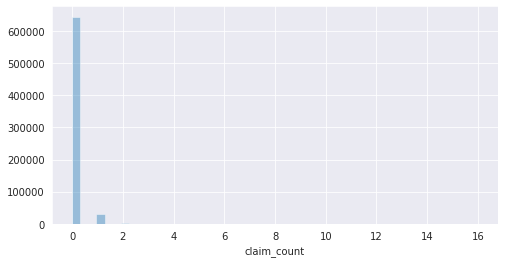

In [8]:
plt.figure(figsize=(8,4))
sns.distplot(Input_df['claim_count'],kde=False)
print(Input_df['claim_count'].value_counts())

The distribution is skewed & not a decent spread. 

## Converting Target Variable into Buckets


> Given the distribution of the target variable, we will split the target into 4 buckets
1.   No_Claims
2.   1_Claim
1.   2_Or_3_Claims
2.   More_Than_3_Claims

This converts the problem into a Multi-Class Classification with Imbalance

*Create a copy of the dataset to workupon, retaining the original dataframe as is*





In [95]:
Data_copy_df = Input_df.copy()

Data_copy_df['Num_of_Claims'] = np.where(Data_copy_df['claim_count']==0,'No_Claims',
                                         np.where(Data_copy_df['claim_count']==1,'1_Claim',
                                         np.where(((Data_copy_df['claim_count'] ==2) | (Data_copy_df['claim_count']==3)),'2_Or_3_Claims','More_Than_3_Claims')
                                         ))
print(Data_copy_df['Num_of_Claims'].value_counts())

No_Claims             643919
1_Claim                32176
2_Or_3_Claims           1866
More_Than_3_Claims        16
Name: Num_of_Claims, dtype: int64


Now we have 4 target classes



---



In [97]:
Data_copy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677977 entries, 0 to 678012
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   policy_desc                 677977 non-null  int64 
 1   claim_count                 677977 non-null  int64 
 2   cat_areacode                677977 non-null  object
 3   num_vehicleAge              677977 non-null  int64 
 4   num_noClaimDiscountPercent  677977 non-null  int64 
 5   cat_carBrand                677977 non-null  object
 6   num_populationDensitykmsq   677977 non-null  int64 
 7   cat_Region                  677977 non-null  object
 8   ord_vehicleHP               677977 non-null  int64 
 9   num_exposure                677977 non-null  object
 10  cat_fuelType                677977 non-null  object
 11  num_driverAge               677977 non-null  object
 12  Num_of_Claims               677977 non-null  object
dtypes: int64(6), object(7)
memory

## Check Values in Each Column
#### Exposure & Driver Age Col names states that to be numeric, but data type is object. Check for any inconsistency in values

#### Exposure Column

In [98]:
Data_copy_df.loc[Data_copy_df['num_exposure'].apply(lambda x: x.isalnum())]['num_exposure'].value_counts()

1          168101
23years        27
37years        27
10years        17
2               1
Name: num_exposure, dtype: int64

Exposure column, though should contain numeric data as per naming convention, seems to contain data entry issues like above. For example, 37 is entered as 37 years. There are about 168173 rows with such issues. Rest of the values are float. 
To bring consistency, let's convert this to float column

In [134]:
def fun_fix_Exposure(x):
  if x.isalnum():
    res = re.findall(r"\d+",x)[0]
  else:
    res=x
  return res

In [135]:
Data_copy_df['num_exposure'] = Data_copy_df['num_exposure'].apply(fun_fix_Exposure)

#### Driver Age Column


In [79]:
Data_copy_df.loc[Data_copy_df['num_driverAge'].apply(lambda x: not str(x).isdigit())]['num_driverAge']

258         
105969      
165364      
212991      
217702      
          ..
624661      
624718      
635940      
650714      
676421      
Name: num_driverAge, Length: 65554, dtype: object

Driver Age column contains blank values for about 65000 records. This is again missing values that needs to be treated

In [110]:
def fun_fix_DriverAge(x):
  if not str(x).isdigit():
    res = np.nan
  else:
    res=x
  return res

In [111]:
Data_copy_df['num_driverAge'] = Data_copy_df['num_driverAge'].apply(fun_fix_DriverAge)

In [138]:
Data_copy_df.isna().sum()

policy_desc                       0
claim_count                       0
cat_areacode                      0
num_vehicleAge                    0
num_noClaimDiscountPercent        0
cat_carBrand                      0
num_populationDensitykmsq         0
cat_Region                        0
ord_vehicleHP                     0
num_exposure                      0
cat_fuelType                      0
num_driverAge                 65554
Num_of_Claims                     0
dtype: int64

DriverAge column has 65554 missing values, which we will fix at later stage using KNNImputer

In [145]:
Data_copy_df['ord_vehicleHP'] = Data_copy_df['ord_vehicleHP'].astype('object')
Data_copy_df['num_exposure'] = Data_copy_df['num_exposure'].astype('float64')
Data_copy_df['num_driverAge'] = Data_copy_df['num_driverAge'].astype('float64')

## Rename columns

In [146]:
Col_names = {'num_vehicleAge':'Vehicle_Age','num_noClaimDiscountPercent':'No_Claim_Discount_Perc','num_populationDensitykmsq':'Population_Density_KmSq',
             'cat_areacode':'Area_Code','cat_carBrand':'Car_Brand','ord_vehicleHP':'Vehicle_HP','num_exposure':'Policy_Exposure_Time',
             'cat_fuelType':'Fuel_Type','num_driverAge':'Driver_Age'}
Data_copy_df.rename(Col_names,axis=1,inplace=True)
Data_copy_df.head()

,policy_desc,claim_count,Area_Code,Vehicle_Age,No_Claim_Discount_Perc,Car_Brand,Population_Density_KmSq,cat_Region,Vehicle_HP,Policy_Exposure_Time,Fuel_Type,Driver_Age,Num_of_Claims
0,1,1,D,0,50,B12,1217,R82,5,0.10,Regular,55.0,1_Claim
1,3,1,D,0,50,B12,1217,R82,5,0.77,Regular,55.0,1_Claim
2,5,1,B,2,50,B12,54,R22,6,0.75,Diesel,52.0,1_Claim
3,10,1,B,0,50,B12,76,R72,7,0.09,Diesel,46.0,1_Claim
4,11,1,B,0,50,B12,76,R72,7,0.84,Diesel,46.0,1_Claim


In [148]:
Num_cols = []
Cat_Cols = []
for i in Data_copy_df.columns:
  if (Data_copy_df[i].dtype!='O'):
    Num_cols.append(i)
  elif (Data_copy_df[i].dtype=='O'):
    Cat_Cols.append(i)
  else :
    print("Data Type for column {} undefined".format(i))

Num_cols.remove('policy_desc')
Num_cols.remove('claim_count')
print("Numeric Columns : ",Num_cols)
print("Categorical Columns: ",Cat_Cols)

Numeric Columns :  ['Vehicle_Age', 'No_Claim_Discount_Perc', 'Population_Density_KmSq', 'Policy_Exposure_Time', 'Driver_Age']
Categorical Columns:  ['Area_Code', 'Car_Brand', 'cat_Region', 'Vehicle_HP', 'Fuel_Type', 'Num_of_Claims']


## Distribution of Numeric Columns

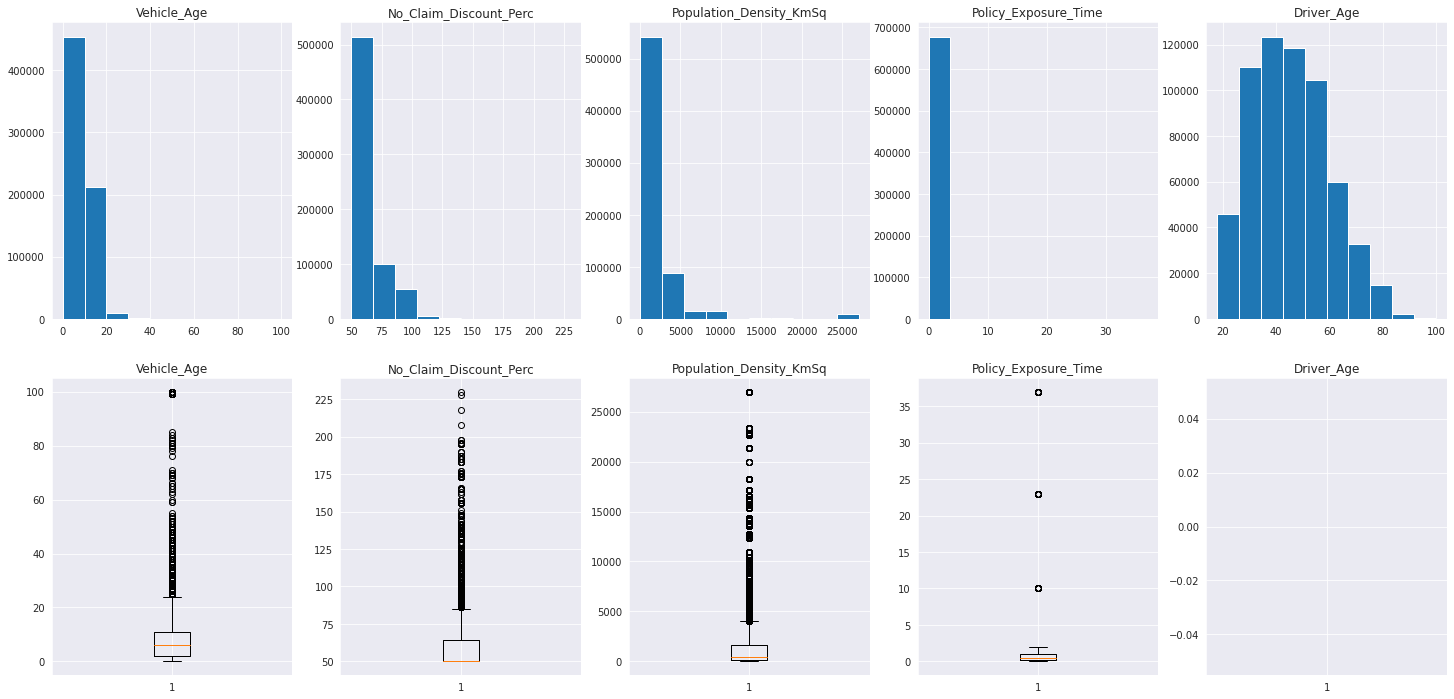

In [159]:
fig, ax = plt.subplots(nrows=2,ncols=len(Num_cols),figsize=(25,12))

for i,col_name in enumerate(Num_cols):
  ax[0,i].hist(Data_copy_df[col_name])
  ax[0,i].title.set_text(col_name)
  ax[1,i].boxplot(Data_copy_df[col_name])
  ax[1,i].title.set_text(col_name)


Except for Driver Age, rest of the numeric columns are skewed.
Also, 3 extreme outliers for Policy Exposure Time. Policies that are more than 10 years. Need to verify the authenticity of it.